# Data Processing and Some Analysis

In [1]:
import pandas as pd # version 1.1.1
import spacy # version 2.2.4
import matplotlib.pyplot as plt # version 3.2.1
import sklearn.feature_extraction # version 0.22.2
import sklearn.metrics.pairwise # version 0.22.2
import seaborn as sns # version 0.10.0

In [2]:
# load the original data
original_df = pd.read_pickle('scraped_data.pkl')

## Data Preprocessing

In [3]:
# codes written by Bhargave Desiken, used in course Computational Content analysis
# https://github.com/Computational-Content-Analysis-2020/lucem_illud_2020/blob/master/lucem_illud_2020/proccessing.py

nlp = spacy.load("en")

def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):
    
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

def normalizeTokens(word_list, extra_stop=[], model=nlp, lemma=True, MAX_LEN=1500000):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "tagger", "ner"])

    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    # we check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.lemma_))
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.text.strip()))

    return normalized

In [4]:
# keep only the comments that were within the deadline
df = original_df[original_df['time_to_deadline'] <= 0].copy()

In [5]:
# adding a talker column to label data better
talkerDf = pd.DataFrame({'2019-10-10': 'Greene', '2019-10-17':'Evans', '2019-10-24':'Turner', '2019-10-31':'Bergstrom',
              '2019-11-07': 'King', '2019-11-14': 'Terman', '2020-01-09': 'Boudourides', '2020-01-16':'Parigi',
              '2020-01-23': 'Wang', '2020-01-30': 'Becker', '2020-02-06':'Boutyline', '2020-02-27':'Ferrari',
              '2020-03-06': 'Youn', '2020-04-09':'Bainbridge', '2020-04-30':'Munro', '2020-05-07':'State',
              '2020-05-14': 'Zheng', '2020-05-21': 'Lewis', '2020-05-28':'Shaw'}, index=[0]).T.reset_index()
talkerDf.columns = ['workshop_date', 'talker']
df = df.merge(talkerDf)

In [6]:
# add a quarter column to label data better (probably not going to use)
workshop_date = df['workshop_date'].unique()
quarters = ['F', 'F', 'F', 'F', 'F', 'F', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'S', 'S', 'S', 'S', 'S', 'S']
quarterDf = pd.DataFrame({'workshop_date':workshop_date, 'quarter':quarters})
df = df.merge(quarterDf)

In [7]:
# tokenizing and normalizing (includes lemmatizing) tokens
df['tokenized_words'] = df['text'].apply(lambda x: word_tokenize(x))
df['normalized_words'] = df['tokenized_words'].apply(lambda x: normalizeTokens(x))

In [8]:
# count the words to see if we need any extra stop words
countsDict = {}
for word in df['normalized_words'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('thank', 1183),
 ('presentation', 572),
 ('think', 521),
 ('interest', 479),
 ('question', 471),
 ('social', 452),
 ('model', 422),
 ('paper', 415),
 ('research', 407),
 ('datum', 381),
 ('people', 379),
 ('wonder', 326),
 ('medium', 324),
 ('work', 302),
 ('like', 289),
 ('different', 251),
 ('share', 250),
 ('learn', 233),
 ('network', 227),
 ('topic', 223)]

In [9]:
# normalize again with additional custom stop words
extra_stop = ['thank', 'presentation', 'present', 'think', 'interest', 'question']
df['normalized_words'] = df['tokenized_words'].apply(lambda x: normalizeTokens(x, extra_stop=extra_stop))

In [10]:
# add a text length column for later use
df['text_length'] = df['normalized_words'].apply(len)

In [11]:
# save the processed dataframe
df.to_pickle('processed_data.pkl')

In [12]:
# save for statistical analysis in R
df[['name', 'workshop_date', 'position', 'text_length', 'num_upvotes', 'talker', 'quarter']].to_csv('processed_data.csv')

## TF-IDF Calculation

In [13]:
# agrregate all the normalized words by talker
# note that I am NOT using the raw text but acculumation of normalized tokens
agg_raw_docs = df.groupby(['talker'])['normalized_words'].sum().apply(lambda x: ' '.join(x))
# initialize the TF-IDF vectorizer and fit/transform the docs
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(norm='l2')
TFVects = TFVectorizer.fit_transform(agg_raw_docs)
TFArray = TFVects.toarray()
# constructe dataframe for easier view
TFDf = pd.DataFrame(index=range(5))
for counter, doc in enumerate(TFArray):
    tf_idf_tuples = list(zip(TFVectorizer.get_feature_names(), doc))
    talker = agg_raw_docs.index[counter]
    c1 = talker + ' term'
    c2 = talker + ' score'
    TFDf = TFDf.merge(pd.DataFrame.from_records(tf_idf_tuples, columns=[c1, c2]).sort_values(by=c2, ascending=False).reset_index(drop=True),
                      left_index=True, right_index=True)

In [14]:
# sanity check
TFDf

,Bainbridge term,Bainbridge score,Becker term,Becker score,Bergstrom term,Bergstrom score,Boudourides term,Boudourides score,Boutyline term,Boutyline score,...,Terman term,Terman score,Turner term,Turner score,Wang term,Wang score,Youn term,Youn score,Zheng term,Zheng score
0,memory,0.525740,group,0.359733,bullshit,0.908457,network,0.513362,gender,0.578399,...,muslim,0.536968,medium,0.497798,failure,0.557989,distance,0.420986,privacy,0.579361
1,recall,0.483094,discussion,0.258742,orientation,0.099285,social,0.304946,woman,0.194665,...,medium,0.381904,social,0.353183,setback,0.358893,collaboration,0.391615,device,0.316738
2,image,0.345102,belief,0.214615,datum,0.088685,decomposition,0.257366,word,0.189581,...,woman,0.318498,democracy,0.192737,career,0.315724,geographical,0.359769,jam,0.207003
3,participant,0.158453,unstructured,0.188570,sexual,0.078386,ego,0.225944,connotation,0.188589,...,bias,0.222617,authoritarianism,0.179472,success,0.228396,paper,0.214929,datum,0.202785
4,object,0.158407,decision,0.154533,call,0.077772,dominate,0.200378,educational,0.179792,...,report,0.192543,internet,0.170939,grant,0.209128,learn,0.168942,smart,0.158296


In [15]:
# print out the top TF-IDF words for inspection
for name in agg_raw_docs.index:
    print('Dr. ' + name + ': ' + ', '.join(TFDf[name + ' term']))

Dr. Bainbridge: memory, recall, image, participant, object
Dr. Becker: group, discussion, belief, unstructured, decision
Dr. Bergstrom: bullshit, orientation, datum, sexual, call
Dr. Boudourides: network, social, decomposition, ego, dominate
Dr. Boutyline: gender, woman, word, connotation, educational
Dr. Evans: novelty, breakthrough, research, team, distant
Dr. Ferrari: hdpglm, glm, model, latent, heterogeneity
Dr. Greene: medical, diagnosis, medicine, patient, datum
Dr. King: compactness, district, method, science, measure
Dr. Lewis: gender, language, stereotype, association, linguistic
Dr. Munro: learn, active, human, machine, label
Dr. Parigi: trust, airbnb, propensity, platform, guest
Dr. Shaw: bitcoin, value, currency, agent, model
Dr. State: facebook, network, college, friend, fb
Dr. Terman: muslim, medium, woman, bias, report
Dr. Turner: medium, social, democracy, authoritarianism, internet
Dr. Wang: failure, setback, career, success, grant
Dr. Youn: distance, collaboration, ge

## Cluster map using TF-IDF cosine similarity

Text(721.7499999999999, 0.5, '')

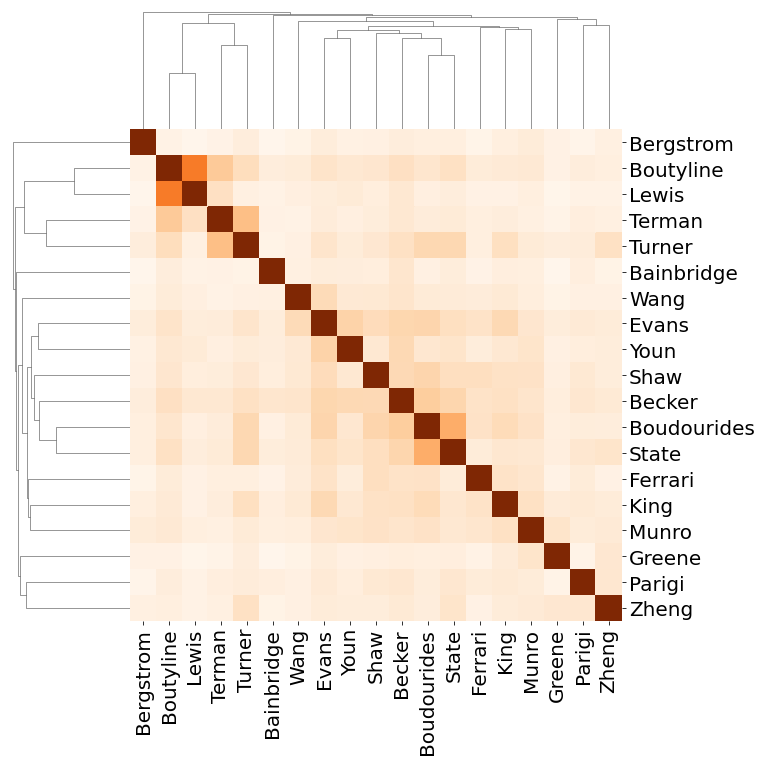

In [16]:
# calculate the cosine similarities
# since we used l2 norm in TFIDF vectorizers this is just equivalent to applying linear kernel
cos_sims = sklearn.metrics.pairwise.linear_kernel(TFVects)
cos_sim_df = pd.DataFrame(cos_sims, index=agg_raw_docs.index, columns=agg_raw_docs.index)
g =sns.clustermap(cos_sim_df, cmap='Oranges', cbar_pos=None)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 20)
plt.xlabel('')
plt.ylabel('')

# Stuffs that did not make it into the slides

In [17]:
import wordcloud # version 1.6.0
import numpy as np # version 1.19.1
import sklearn.linear_model # version 0.22.2
#import nltk
#import scipy


## histogram of number of overtime comments for workshops

Text(0.5, 1.0, 'number of overtime comments')

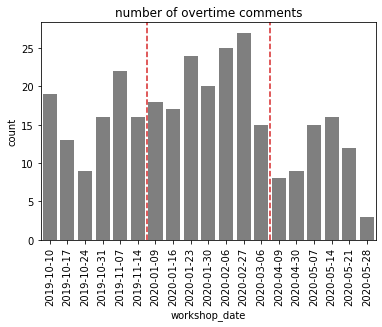

In [18]:
overtime = original_df[original_df['time_to_deadline'] > 0]
sns.countplot(overtime['workshop_date'], color='tab:gray')
plt.xticks(rotation=90)
plt.axvline(x=5.5, ls='--', color='tab:red')
plt.axvline(x=12.5, ls='--', color='tab:red')
plt.title('number of overtime comments')

## Word Cloud

In [19]:
# create df that accumulates all the normalized words by talker
agg_words_all = df.groupby(['talker'])['normalized_words'].apply(list).apply(lambda x: [item for sublist in x for item in sublist])

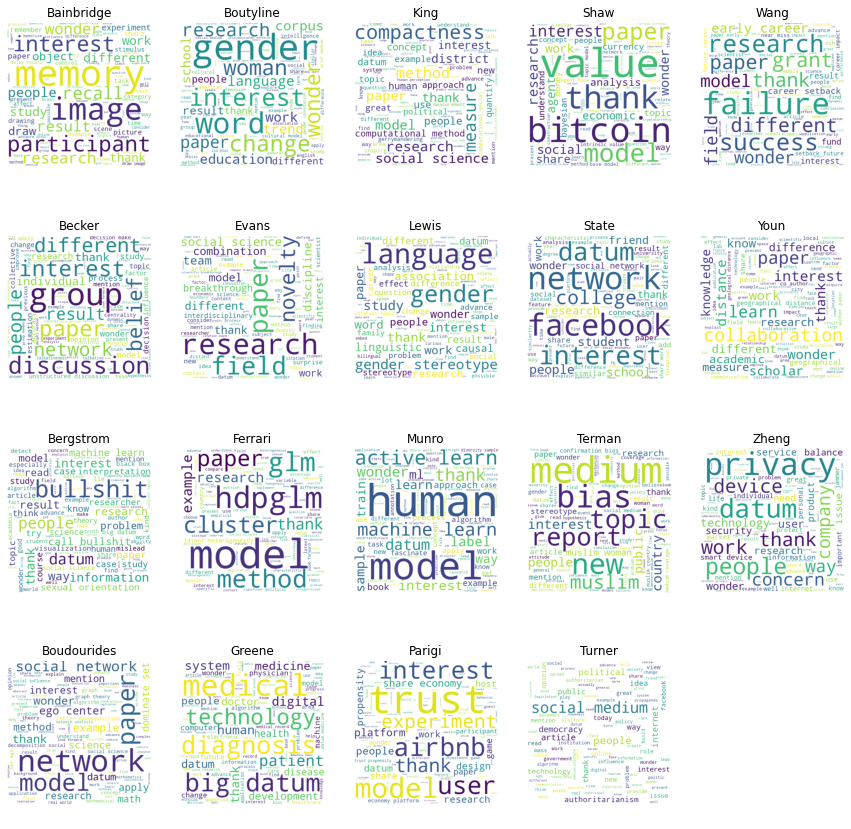

In [20]:
# visualize the word cloud: this probably won't make it into the slides...
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(15,15))
for col in range(5):
    for row in range(4):
        if col == 4 and row == 3:
            ax[row][col].axis("off")
            break
        agg_words = agg_words_all[col * 4 + row]
        wc = wordcloud.WordCloud(background_color="white", max_words=100, mode ='RGBA', width=500, height=500).generate(' '.join(agg_words))
        ax[row][col].imshow(wc)
        ax[row][col].axis("off")
        ax[row][col].set_title(agg_words_all.index[col * 4 + row])

## Average Cosine Similarity barplot
turned out clustermap is enough to talk about...

Text(0, 0.5, '')

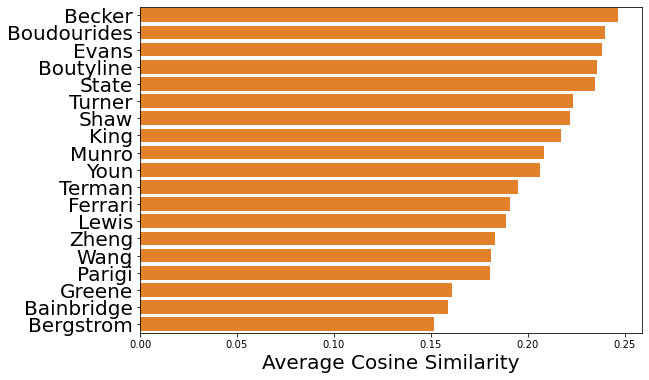

In [21]:
fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data=pd.DataFrame(cos_sim_df.apply(np.average, axis=1).sort_values(ascending=False)).reset_index(), 
            x= 0, y='talker', color='tab:orange', ax=ax)
plt.xlabel('Average Cosine Similarity', size=20)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_ylabel('')

## Heterogenity Within a talk (based on TF-IDF cosine similarity calculation in individual comment level, not aggregated-per-talk level)

In [22]:
# heterogenity within talker
heterogenity = {}
for talker in df['talker'].unique():
    df_parse = df[df['talker'] == talker]
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(norm='l2')
    TFVects = TFVectorizer.fit_transform(df_parse['normalized_words'].apply(lambda x: ' '.join(x)))
    cos_sim_talker = sklearn.metrics.pairwise.linear_kernel(TFVects)
    heterogenity[talker] = np.average(cos_sim_talker)

Text(0, 0.5, '')

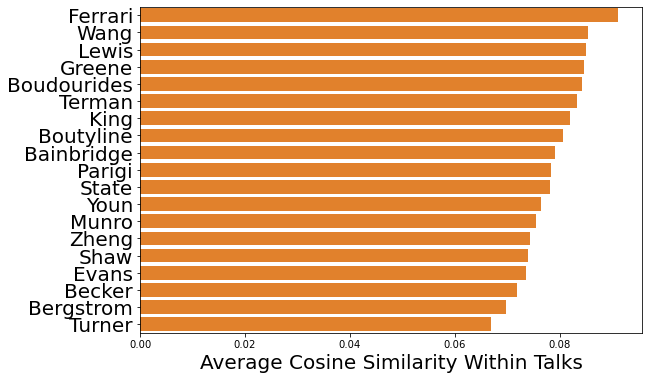

In [23]:
fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data = pd.DataFrame(heterogenity, index=[0]).T.reset_index().sort_values(0, ascending=False),
            y='index', x=0, color='tab:orange', ax=ax)
ax.set_xlabel('Average Cosine Similarity Within Talks', size=20)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_ylabel('')

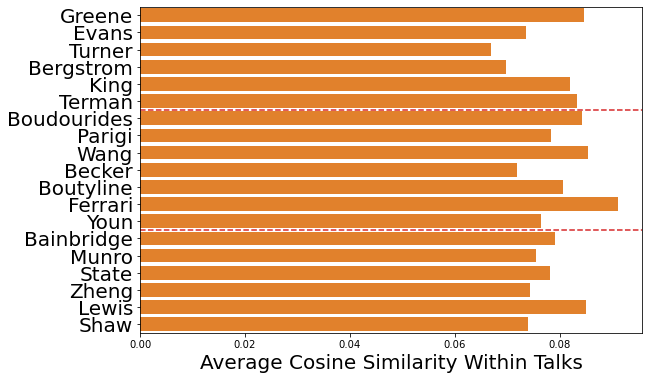

In [24]:
fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data = pd.DataFrame(heterogenity, index=[0]).T.reset_index(),
            y='index', x=0, color='tab:orange', ax=ax)
ax.set_xlabel('Average Cosine Similarity Within Talks', size=20)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_ylabel('')
plt.axhline(y=5.5, linestyle='--', color='tab:red')
plt.axhline(y=12.5, linestyle='--', color='tab:red')

## Coefficient change for `position` when we fit `num_upvotes` ~ `position`

In [25]:
coef_lst = []
for date in df['workshop_date'].unique():
    tmp_df = df[df['workshop_date'] == date]
    X = tmp_df['position'].to_numpy().reshape(-1, 1)
    y = tmp_df['num_upvotes'].to_numpy().reshape(-1, 1)
    reg = sklearn.linear_model.LinearRegression().fit(X, y)
    coef_lst.append(reg.coef_[0][0])

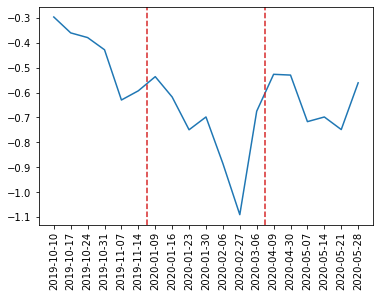

In [26]:
sns.lineplot(y=coef_lst, x=df['workshop_date'].unique())
plt.xticks(rotation=90)
plt.axvline(x=5.5, ls='--', color='tab:red')
plt.axvline(x=12.5, ls='--', color='tab:red')